In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Torch version: 2.11.0.dev20251228+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5050 Laptop GPU


In [2]:
torch.backends.cudnn.benchmark = True


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # 🔥 REDUCED
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # 🔥 REDUCED
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
data_dir = "/home/sachi/datasets/Project_Data"

train_dataset = datasets.ImageFolder(
    root=f"{data_dir}/train",
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=f"{data_dir}/val",
    transform=val_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,      # 🔥 REDUCED
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,      # 🔥 REDUCED
    shuffle=False,
    num_workers=0,
    pin_memory=False
)


print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Classes: ['0_real', '1_fake']
Train samples: 100000
Val samples: 20000


In [8]:
class DualStreamNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Stream 1 (Xception-like)
        self.stream1 = models.efficientnet_b4(weights="IMAGENET1K_V1")
        self.stream1.classifier = nn.Identity()

        # Stream 2 (DenseNet)
        self.stream2 = models.densenet121(weights="IMAGENET1K_V1")
        self.stream2.classifier = nn.Identity()

        # Fusion head
        self.fc = nn.Sequential(
            nn.Linear(1792 + 1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        f1 = self.stream1(x)
        f2 = self.stream2(x)
        fused = torch.cat([f1, f2], dim=1)
        return self.fc(fused)


In [6]:
model = DualStreamNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print("Model on device:", next(model.parameters()).device)


Model on device: cuda:0


In [7]:
def train_one_epoch(model, loader, epoch):
    model.train()
    running_loss = 0.0

    progress = tqdm(loader, desc=f"Epoch {epoch} [TRAIN]")

    for images, labels in progress:
        images = images.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    return running_loss / len(loader)


In [8]:
def validate(model, loader, epoch):
    model.eval()
    correct = 0
    total = 0

    progress = tqdm(loader, desc=f"Epoch {epoch} [VAL]")

    with torch.no_grad():
        for images, labels in progress:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [9]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, epoch)
    val_acc = validate(model, val_loader, epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )


Epoch 1 [VAL]: 100%|████████████████████| 2500/2500 [01:52<00:00, 22.17it/s]


Epoch 1/10 | Train Loss: 0.1613 | Val Acc: 0.9737


Epoch 2 [VAL]: 100%|████████████████████| 2500/2500 [01:37<00:00, 25.56it/s]


Epoch 2/10 | Train Loss: 0.0828 | Val Acc: 0.9720


Epoch 3 [VAL]: 100%|████████████████████| 2500/2500 [01:34<00:00, 26.54it/s]


Epoch 3/10 | Train Loss: 0.0567 | Val Acc: 0.9791


Epoch 4 [VAL]: 100%|████████████████████| 2500/2500 [01:35<00:00, 26.20it/s]


Epoch 4/10 | Train Loss: 0.0427 | Val Acc: 0.9817


Epoch 5 [VAL]: 100%|████████████████████| 2500/2500 [01:34<00:00, 26.41it/s]


Epoch 5/10 | Train Loss: 0.0344 | Val Acc: 0.9850


Epoch 6 [VAL]: 100%|████████████████████| 2500/2500 [01:34<00:00, 26.35it/s]


Epoch 6/10 | Train Loss: 0.0290 | Val Acc: 0.9841


Epoch 7 [VAL]: 100%|████████████████████| 2500/2500 [01:44<00:00, 23.84it/s]


Epoch 7/10 | Train Loss: 0.0229 | Val Acc: 0.9836


Epoch 8 [VAL]: 100%|████████████████████| 2500/2500 [01:38<00:00, 25.37it/s]


Epoch 8/10 | Train Loss: 0.0208 | Val Acc: 0.9857


Epoch 9 [VAL]: 100%|████████████████████| 2500/2500 [01:36<00:00, 25.88it/s]


Epoch 9/10 | Train Loss: 0.0175 | Val Acc: 0.9835


Epoch 10 [VAL]: 100%|███████████████████| 2500/2500 [01:37<00:00, 25.63it/s]

Epoch 10/10 | Train Loss: 0.0169 | Val Acc: 0.9859


In [10]:
torch.save(model.state_dict(), "dual_stream_final.pth")
print("Final model saved.")


Final model saved.


In [11]:
eval_model = DualStreamNet().to(device)
eval_model.load_state_dict(torch.load("dual_stream_final.pth", map_location=device))
eval_model.eval()

print("Model loaded for evaluation.")


Model loaded for evaluation.


In [12]:
import numpy as np

y_true = []
y_probs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Collecting predictions"):
        images = images.to(device)
        outputs = eval_model(images)
        probs = torch.sigmoid(outputs)

        y_true.extend(labels.numpy())
        y_probs.extend(probs.cpu().numpy().flatten())

y_true = np.array(y_true)
y_probs = np.array(y_probs)

print("Prediction collection done.")


Prediction collection done.


In [14]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (y_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))


Confusion Matrix:
 [[9804  196]
 [  87 9913]]

Classification Report:

              precision    recall  f1-score   support

        Real       0.99      0.98      0.99     10000
        Fake       0.98      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



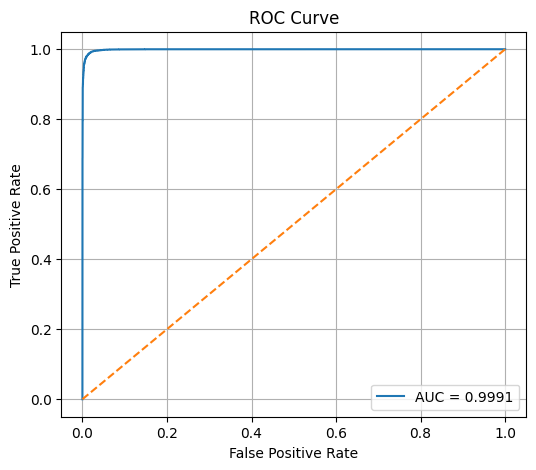

ROC-AUC: 0.9990654


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print("ROC-AUC:", roc_auc)


In [17]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x, class_idx=0):
        self.model.zero_grad()
        output = self.model(x)
        output[:, class_idx].backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


In [6]:
import cv2

# Pick one validation image
image, label = val_dataset[0]
input_tensor = image.unsqueeze(0).to(device)

# Use EfficientNet last conv layer
target_layer = eval_model.stream1.features[-1]

gradcam = GradCAM(eval_model, target_layer)
cam = gradcam.generate(input_tensor)

# Convert to numpy
cam = cam.detach().cpu().numpy()[0]


# Resize CAM to image size
cam = cv2.resize(cam, (224, 224))

# Prepare image for display
img = image.permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM | Label: {label}")
plt.axis("off")
plt.show()


NameError: name 'val_dataset' is not defined

In [9]:
demo_model = DualStreamNet().to(device)
demo_model.load_state_dict(
    torch.load("dual_stream_final.pth", map_location=device)
)
demo_model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [11]:
from PIL import Image

demo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

image_path = "/mnt/c/Users/sachi/Desktop/genesis/test/pussy.jpeg"  # 👈 CHANGE THIS

img_pil = Image.open(image_path).convert("RGB")
input_tensor = demo_transform(img_pil).unsqueeze(0).to(device)

print("Transform and image loaded.")


Transform and image loaded.


In [12]:
with torch.no_grad():
    logit = demo_model(input_tensor)
    prob = torch.sigmoid(logit).item()

label = "FAKE" if prob > 0.5 else "REAL"

print("Prediction:", label)
print("Confidence:", round(prob, 4))


Prediction: FAKE
Confidence: 1.0


In [13]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x):
        self.model.zero_grad()
        output = self.model(x)
        output.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam


In [17]:
import numpy as np
import matplotlib.pyplot as plt


/home/sachi/ai_use/lib/python3.10/site-packages/torch/nn/modules/module.py:1871: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


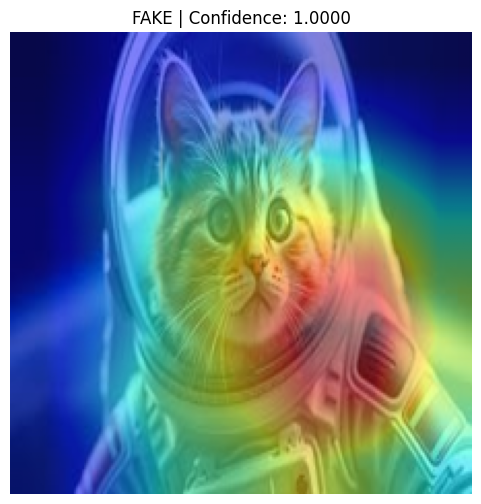

In [18]:
target_layer = demo_model.stream1.features[-1][0]
gradcam = GradCAM(demo_model, target_layer)

cam = gradcam.generate(input_tensor)
cam = cam.detach().cpu().numpy()[0]
cam = cv2.resize(cam, (224, 224))

img_np = np.array(img_pil.resize((224, 224))) / 255.0

plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title(f"{label} | Confidence: {prob:.4f}")
plt.axis("off")
plt.show()
